# Data Preprocessing

The data is formatted as JSON separated by newline. Using pandas to read dataset

In [1]:
import pyspark.pandas as pd
import matplotlib.pyplot as plt

dataframe = pd.read_json("./Software_5.json", lines=True)

print(dataframe.info(verbose=True))


c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_json`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 12805 entries, 0 to 12804
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   asin            12805 non-null  object 
 1   image           71 non-null     object 
 2   overall         12805 non-null  float64
 3   reviewText      12804 non-null  object 
 4   reviewTime      12805 non-null  object 
 5   reviewerID      12805 non-null  object 
 6   reviewerName    12796 non-null  object 
 7   style           7161 non-null   object 
 8   summary         12799 non-null  object 
 9   unixReviewTime  12805 non-null  int64  
 10  verified        12805 non-null  bool   
 11  vote            3902 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)None


The feature `vote` tells us if the review is helpful or not. To better classifying our data, we want to remove all reviews that have no vote.

Also, note that the data type of `vote` is `object`. But since vote can only be a number, we want to convert vote to `int64` data type

Now after preprocessing the vote, we can see that the data type of vote is `int64`

In [2]:
df = dataframe[dataframe['vote'].notna()]

# Some vote has , in number, we just need to remove it
processed_vote = df['vote'].apply(lambda x: x.replace(",", ""))
df['vote'] = pd.to_numeric(processed_vote)

df.info()

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 3902 entries, 2 to 12798
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   asin            3902 non-null   object 
 1   image           53 non-null     object 
 2   overall         3902 non-null   float64
 3   reviewText      3902 non-null   object 
 4   reviewTime      3902 non-null   object 
 5   reviewerID      3902 non-null   object 
 6   reviewerName    3897 non-null   object 
 7   style           1975 non-null   object 
 8   summary         3898 non-null   object 
 9   unixReviewTime  3902 non-null   int64  
 10  verified        3902 non-null   bool   
 11  vote            3902 non-null   float32
dtypes: bool(1), float32(1), float64(1), int64(1), object(8)

For feature `reviewText`, we want to do some pre processing steps on the text. Notably:

- Lemmetization  
- Expand contraction   
- Lower all words

In [13]:
import nltk
import string
import contractions
nltk.download('stopwords')

def remove_special_symbol(text: str) -> str:
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def lower_text(text: str) -> str:
    return text.lower()


def remove_stop_words(text: str) -> str:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    return ' '.join(
        [word for word in text.split() if word not in (stop_words)])


def expand_contraction(text: str) -> str:
    return contractions.fix(text)


def stemming(text: str) -> str:
    stemmer = nltk.stem.SnowballStemmer("english")
    return stemmer.stem(text)

df["processed_review"] = df["reviewText"].apply(lower_text).apply(expand_contraction).apply(
    remove_stop_words).apply(remove_special_symbol).apply(stemming)




[nltk_data] Downloading package stopwords to C:\Users\Long Viet
[nltk_data]     Ta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Each review is assigned an overall score from 1.0 to 5.0. Convert those scores to labels where -1 is negative, 0 is neutral and 1 is positive

In [9]:
def sentiment_from_overall(number):
    if number < 3.0:
        return -1
    if number == 3.0:
        return 0
    return 1

df["sentiment"] = df["overall"].apply(sentiment_from_overall)

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  fields = [
c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


# Visualization

Exploratory data analysis on overall rating column

In [14]:
df["overall"].describe()


count    3902.000000
mean        3.367760
std         1.557351
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64

Plotting pie chart and bar chart for overall score distribution. The 'overall' column has 5 labels: 1.0, 2.0, 3.0, 4.0, 5.0 where 1.0 is very bad, 3.0 is neutral and 5.0 is very good.

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.



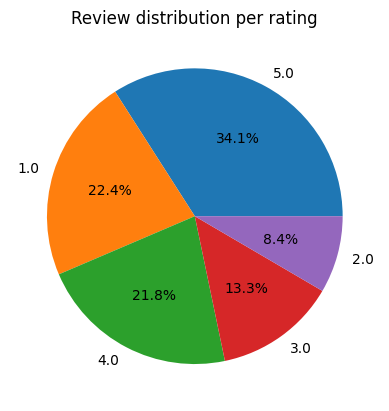

In [15]:
scores = df["overall"].value_counts()
index = scores.index.to_numpy()
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per rating")
plt.show()
df['overall'].value_counts().plot(kind='bar',title="Review count per rating")


We get the same statistic, but this time with sentiment

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.



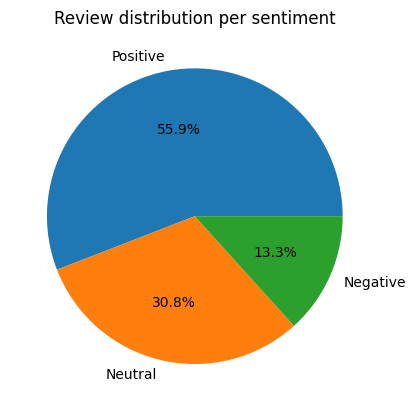

In [12]:
def sentiment_to_word(number):
    if number == 1:
        return "Positive"
    if number == 0:
        return "Negative"
    return "Neutral"

scores = df["sentiment"].value_counts()
index = [sentiment_to_word(x) for x in scores.index.to_numpy()]
scores = scores.to_numpy()
plt.pie(scores, labels=index, autopct='%1.1f%%')
plt.title("Review distribution per sentiment")
plt.show()
df['sentiment'].value_counts().plot(kind='bar',title="Review count per sentiment")


Now, we get statistics on reivewText length. To visualize this, we use a boxplot

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Statistic of text length
 count     3902.000000
mean      1137.915428
std       1409.747266
min          3.000000
25%        361.000000
50%        734.000000
75%       1430.000000
max      23075.000000
Name: processed_review, dtype: float64


c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.



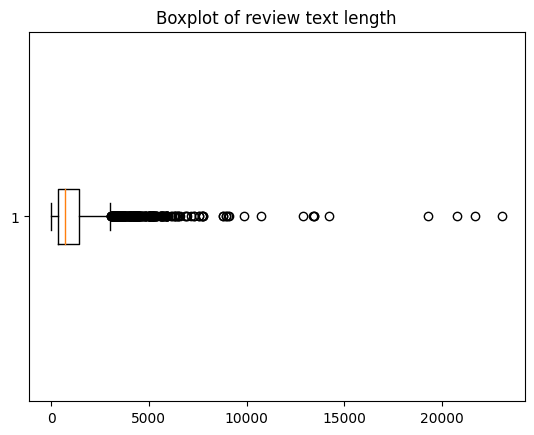

In [16]:
text_length = df["processed_review"].apply(len)
print("Statistic of text length\n", text_length.describe())
# To visualize this, we use boxplot
plt.title("Boxplot of review text length")
plt.boxplot(text_length, vert=False)
plt.show()


Wordcloud to visualize top words in our `processed_review` column

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.



Text(0.5, 1.0, 'Most popular words in dataset')

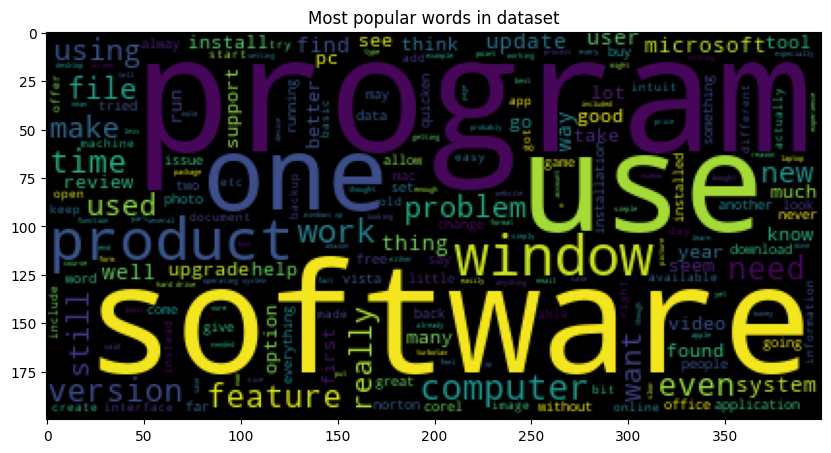

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(df['processed_review'].to_numpy()))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(wordcloud)
ax.set_title("Most popular words in dataset")


Next up, we want to visualize the correlation between `vote` and `rating` in our dataframe. There is no correlation between `vote` and `rating`. Therefore,
we conclude that by removing samples that have no `vote`, it creates no bias for our dataset

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\internal.py:1573: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\sql\pandas\conversion.py:486: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\Long Viet Ta\git\work\Amazon-Reviews-Classifier\env\lib\site-packages\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_numpy` loads all data into the driver's memory. It should only be used if the resulting NumPy ndarray is expected to be small.



(2, 2)


<AxesSubplot: title={'center': 'Correlation between features'}>

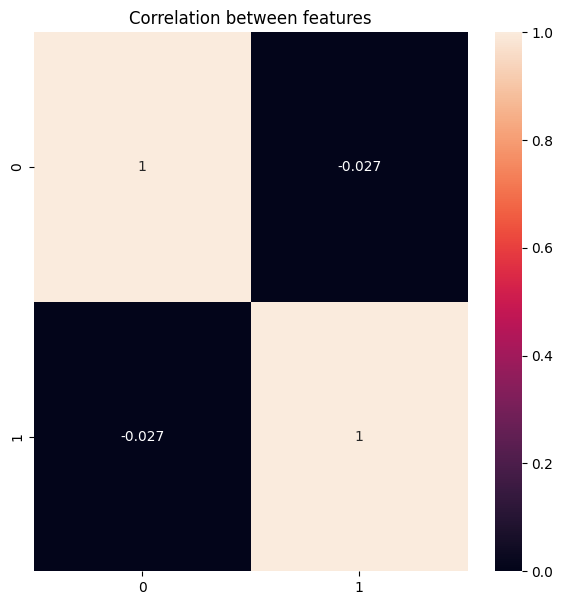

In [49]:
from seaborn import heatmap

correlation = df[["vote", "overall"]].corr().to_numpy()

print(correlation.shape)
plt.figure(figsize=(7, 7))
plt.title("Correlation between features")
heatmap(correlation, vmin=0, vmax=1, annot=True)


# Algorithms

We will separate our data into 3 sets which are `trainning`, `validation` and `testing`.

The trainning step will be used to create our model, we want to config parameters that will generalize well in this step

Validation step will be used for hyperparameter tuning, to maximize our model's accuracy.

Finally, we measure and compare our results using the test set.

We will split the dataset in the following ration: 80, 10 and 10.

In [ ]:
# Split dataset

Next up, we need to extract features from our text data. This will act as an input to our ML model. There are many options that we can choose from, notably:

1, **TF-IDF**: Stands for Term Frequency – Inverse Document Frequency

2, **Count Vectorizer**

We will use TF-IDF for feature extraction. The reason is that Count Vectorizer only focuses on the frequency of the word, which results in biasing in favour of popular words. For example, the word `the` will be counted a lot but does not hold any significant meaning. Meanwhile, using TF-IDF, we can avoid common words that does not carry any sentiment

In [ ]:
# Use TF IDF

Next up, we will train our model using `Logistic Regression`

In [ ]:
# Train model with Logistic Regression

Visualizing the result

In [ ]:
# Show accuracy score, f1 score, recall score and confusion matrix